In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
# library(Seurat)
library(CellChat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 载入需要的程辑包：igraph

R[write to console]: 
载入程辑包：‘igraph’


R[write to console]: The following objects are masked from ‘package:lubridate’:

    %--%, union


R[write to console]: The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:purrr’:

    compose, simplify


R[write to console]: The following object is masked from ‘package:tidyr’:

    crossing


R[write to console]: The following object is masked from ‘package:tibble’:

    as_data_frame


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union





    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
%%R
# in R
adata1 = dior::read_h5(file='/home/maolp/data5/Gaofeng_All_matrix/Allcount/Last_All_scanpyData/Data/scdata.h5', target.object = 'seurat')

R[write to console]: Warning:
R[write to console]:  No columnames present in cell embeddings, setting to 'PCA_1:50'

R[write to console]: Warning:
R[write to console]:  No columnames present in cell embeddings, setting to 'UMAP_1:2'



In [4]:
%%R
adata1
adata1@meta.data$Last_cell_type %>% unique() 

 [1] CXCR5+ Naïve B       CXCR5- Naïve B       Naïve CD4 T         
 [4] Gamma Delta V2 T     Naïve CD8 T          Classical Monocytes 
 [7] Late_ERY             Treg                 abT(entry)          
[10] CX3CR1+ NK           Macrophages          DN(Q) T             
[13] Mid_ERY              Th17like_INNATE_T    DP(P) T             
[16] CXCR6+ NK            CD14+PPBP+ Monocytes Megakaryocytes      
[19] CD56highCD16low NK   DP(Q) T              Small pre-B         
[22] GNG4 +CD8aa+T        Myeloid-CD177        Early_ERY           
[25] Endothelial cells    NK T                 DC2                 
[28] Pro-B                DC1                  HSC_MPP             
[31] MEP                  ILC2/3               pDC                 
[34] Large pre-B          Tem                  Gamma Delta V1 T    
[37] Others               Cycling Treg         MEMP                
39 Levels: CD14+PPBP+ Monocytes CD56highCD16low NK ... pDC


In [5]:
%%R
adata1@meta.data$Last_cell_typen=adata1@meta.data$Last_cell_type
adata1@meta.data$Last_cell_type=adata1@meta.data$Last_cell_type %>%  gsub("\\(", "", .)%>% gsub("\\)", "", .) 

In [6]:
%%R
# Load the required packages
library(dplyr)
library(stringr)

# Add a new column to the metadata
adata1@meta.data <- adata1@meta.data %>% mutate(
  Category = case_when(
    # Identify the initial letter
    str_detect(AdjustedID, "^B") ~ "PBMC",
    str_detect(AdjustedID, "^L") ~ "Liver",
    str_detect(AdjustedID, "^T") ~ "Thymus",
    str_detect(AdjustedID, "^S") ~ "Spleen",
    TRUE ~ "Other"  # for any other cases
  ),
  NumericPart = as.numeric(str_extract(AdjustedID, "\\d+\\.\\d+")),  # extract the numeric part
  Stage = ifelse(NumericPart <= 26, "Early", "Late")  # classify as "Early" or "Late"
)

adata1@meta.data$GroupStat<-paste0(adata1@meta.data$Category,"_",adata1@meta.data$Stage)

In [7]:
%%R
process_cellchat233 <- function(adata,  id_value) {
  subset_data <- subset(adata, GroupStat== id_value)
  data.pbmc <- subset_data@assays$RNA@data
  # Use cell_type_label as the name of the column to use for group labels
  cellmeta <- data.frame(group = as.character(subset_data$Last_cell_type), row.names = names(subset_data$Last_cell_type))
#   print("test3")
  print(paste("Cellmeta rows: ", nrow(cellmeta)))
  print(paste("Subset data cells: ", length(subset_data@meta.data$Last_cell_type)))
  cellchat <- createCellChat(object = data.pbmc)
  cellchat <- addMeta(cellchat, meta = cellmeta, meta.name = "labels")
  cellchat <- setIdent(cellchat, ident.use = "labels")
  
  CellChatDB <- CellChatDB.human
  CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact", key = "annotation")
  cellchat@DB <- CellChatDB.use
  
  cellchat <- subsetData(cellchat)
  cellchat <- identifyOverExpressedGenes(cellchat)
  cellchat <- identifyOverExpressedInteractions(cellchat)
  cellchat <- projectData(cellchat, PPI.human)

  cellchat <- computeCommunProb(cellchat)
  cellchat <- computeCommunProbPathway(cellchat)
  cellchat <- aggregateNet(cellchat)
  
  return(cellchat)
}




In [8]:
%%R
unique(adata1@meta.data$GroupStat)


[1] "PBMC_Late"    "Spleen_Early" "PBMC_Early"   "Thymus_Early" "Liver_Early" 


In [9]:
%%R
# unique(adata1$GroupStat)
# unique(adata1$Cell_lineage)
subadata1<-subset(adata1,Cell_lineage !="OTHERS")
subadata1<-subset(adata1,Cell_lineage !="MK/ERY")

In [10]:
%%R
# Get a list of all unique AdjustedID values
# # adjusted_ids <- unique(adata1$AdjustedID)
GroupStat_ids <- c( "PBMC_Early","PBMC_Late" ,"Liver_Early","Thymus_Early", "Spleen_Early")
Organ_results <- lapply(GroupStat_ids, function(id) process_cellchat233(adata1, id))
saveRDS(Organ_results, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Organ_results_rmcl.rds")

[1] "Cellmeta rows:  74808"
[1] "Subset data cells:  74808"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~11s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~12s           |+++                                               | 5 % ~12s           |++++                                              | 6 % ~12s           |++++                                              | 7 % ~12s           |+++++                                             | 8 % ~12s           |+++++                                             | 9 % ~12s           |++++++                                            | 10% ~12s           |++++++                                            | 11% ~12s           |+++++++                

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 2 % ~11s           |++                                                | 3 % ~11s           |+++                                               | 4 % ~11s           |+++                                               | 5 % ~11s           |++++                                              | 6 % ~11s           |++++                                              | 8 % ~11s           |+++++                                             | 9 % ~11s           |+++++                                             | 10% ~11s           |++++++                                            | 11% ~11s           |++++++                                            | 12% ~11s           |+++++++                                           | 13% ~11s           |+++++++                                           | 14% ~11s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 2 % ~09s           |++                                                | 4 % ~09s           |+++                                               | 5 % ~09s           |++++                                              | 6 % ~09s           |++++                                              | 7 % ~09s           |+++++                                             | 9 % ~09s           |+++++                                             | 10% ~09s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 13% ~09s           |++++++++                                          | 15% ~09s           |++++++++                                          | 16% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 3 % ~08s           |+++                                               | 4 % ~08s           |+++                                               | 6 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 8 % ~08s           |+++++                                             | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 17% ~08s           |++++++++++                                        | 18% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10s           |++                                                | 2 % ~10s           |++                                                | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~09s           |++++                                              | 8 % ~09s           |+++++                                             | 9 % ~09s           |+++++                                             | 10% ~09s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 14% ~09s           |++++++++                                          | 15% ~09s           |+++++++++                                         | 16% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~16s           |++                                                | 2 % ~12s           |++                                                | 4 % ~12s           |+++                                               | 5 % ~12s           |++++                                              | 6 % ~11s           |++++                                              | 7 % ~12s           |+++++                                             | 9 % ~12s           |+++++                                             | 10% ~12s           |++++++                                            | 11% ~11s           |+++++++                                           | 12% ~11s           |+++++++                                           | 13% ~11s           |++++++++                                          | 15% ~10s           |++++++++                                          | 16% ~10s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 93% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 98% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=08s  
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~13s           |++                                                | 2 % ~10s           |++                                                | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~09s           |+++++                                             | 9 % ~10s           |+++++                                             | 10% ~09s           |++++++                                   

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 3 % ~15s           |+++                                               | 4 % ~25s           |+++                                               | 6 % ~23s           |++++                                              | 7 % ~21s           |+++++                                             | 9 % ~20s           |++++++                                            | 10% ~19s           |++++++                                            | 12% ~18s           |+++++++                                           | 13% ~18s           |++++++++                                          | 15% ~18s           |+++++++++                                         | 16% ~18s           |+++++++++                                         | 18% ~17s           |++++++++++                                        | 19% ~16s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~08s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 7 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 11% ~06s           |+++++++                                           | 13% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 16% ~06s           |++++++++++                                        | 18% ~06s           |++++++++++                                        | 20% ~06s           |+++++++++++                                       | 22% ~05s           |++++++++++++                                      | 24% ~05s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 17% ~02s           |++++++++++                                        | 19% ~02s           |+++++++++++                                       | 20% ~02s           |++++++++++++                                      | 22% ~02s           |+++++++++++++                                     | 24% ~02s           |+++++++++++++                                     | 26% ~02s           |++++++++++++++                                    | 28% ~02s           |+++++++++++++++                                   | 30% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================          

  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-10 22:19:45]"
[1] "Cellmeta rows:  20716"
[1] "Subset data cells:  20716"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~03s           |++++++++                                          | 14% ~02s           |+++++++++                                         | 16% ~02s           |+++++++++                                    

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 18% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s           |++++++++++                                        | 18% ~02s           |++++++++++                                        | 20% ~02s           |+++++++++++                                       | 21% ~02s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 |+++++++++++++++++++++++++++++++++++++++++         | 81% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 82% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 86% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~00s  

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================          

  |                                                                            
  |=================================================                     |  71%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-10 22:28:36]"
[1] "Cellmeta rows:  15289"
[1] "Subset data cells:  15289"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~05s           |++                                                | 3 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~04s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                     

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |+++                                               | 4 % ~04s           |+++                                               | 6 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 14% ~03s           |++++++++                                          | 16% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 19% ~03s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8% ~00s           |++++++++++++++++++++++++++++++++++++              | 72% ~00s           |++++++++++++++++++++++++++++++++++++++            | 76% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 84% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 96% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |                                                  | 0 % ~calculating   |++                                                | 2 % ~02s           |+++                                               | 4 % ~02s           |++++                                              | 6 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                

  |========================                                              |  34%
  |                                                                            
  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================           

  |                                                                            
  |================================================                      |  69%
  |                                                                            
  |=================================================                     |  69%
  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-10 22:34:05]"


In [40]:
%%R
GroupStat_ids <- c( "PBMC_Early","PBMC_Late" ,"Liver_Early","Thymus_Early", "Spleen_Early")
Organ_results2 <- lapply(GroupStat_ids, function(id) process_cellchat233(subadata1, id))
saveRDS(Organ_results, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Organ_results2cll.rds")

[1] "Cellmeta rows:  41934"
[1] "Subset data cells:  41934"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~04s           |++                                                | 3 % ~05s           |+++                                               | 5 % ~05s           |+++                                               | 6 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~05s           |+++++                                             | 9 % ~05s           |++++++                                            | 10% ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 13% ~04s           |+++++++                

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |+++                                               | 4 % ~05s           |+++                                               | 6 % ~05s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |+++++                                             | 10% ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 18% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 2 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~04s           |++++                                              | 7 % ~05s           |+++++                                             | 9 % ~04s           |+++++                                             | 10% ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 12% ~04s           |+++++++                                           | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 16% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~05s           |++                                                | 3 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~04s           |++++                                              | 8 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 12% ~04s           |+++++++                                           | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 18% ~04s           |++++++++++                                        | 20% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |++++++++                                          | 14% ~03s           |++++++++                                          | 16% ~03s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 19% ~03s           |+++++++++++                                       | 21% ~03s           |++++++++++++                                      | 23% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 8 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 12% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 18% ~03s           |++++++++++                                        | 20% ~03s           |+++++++++++                                       | 22% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~04s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |++++++++                                          | 14% ~03s           |++++++++                                          | 16% ~03s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 19% ~03s           |+++++++++++                                       | 21% ~03s           |++++++++++++                                      | 23% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 3 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 19% ~03s           |+++++++++++                                       | 20% ~03s           |++++++++++++                                      | 22% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~04s           |++++                                              | 8 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 12% ~03s           |++++++++                                          | 14% ~03s           |+++++++++                                         | 16% ~03s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 20% ~03s           |+++++++++++                                       | 21% ~03s           |++++++++++++                                      | 23% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~06s           |++                                                | 2 % ~05s           |++                                                | 4 % ~05s           |+++                                               | 5 % ~05s           |+++                                               | 6 % ~05s           |++++                                              | 7 % ~05s           |+++++                                             | 8 % ~05s           |+++++                                             | 10% ~05s           |++++++                                            | 11% ~05s           |++++++                                            | 12% ~05s           |+++++++                                           | 13% ~04s           |++++++++                                          | 14% ~04s           |++++++++                                          | 15% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~04s           |++++                                              | 8 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 14% ~04s           |++++++++                                          | 16% ~04s           |+++++++++                                         | 17% ~04s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~02s           |+++                                               | 4 % ~02s           |++++                                              | 6 % ~03s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~03s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 17% ~02s           |++++++++++                                        | 19% ~02s           |+++++++++++                                       | 21% ~02s           |++++++++++++                                      | 23% ~02s           |+++++++++++++                                     | 26% ~02s           |++++++++++++++                                    | 28% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |+++                                               | 4 % ~04s           |+++                                               | 6 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 16% ~04s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 19% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s           |++++++++++                                        | 18% ~02s           |++++++++++                                        | 20% ~02s           |+++++++++++                                       | 22% ~02s           |++++++++++++                                      | 24% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |++                                                | 3 % ~04s           |+++                                               | 4 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 12% ~04s           |+++++++                                           | 14% ~03s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 16% ~04s           |+++++++++                                         | 18% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 4 % ~03s           |+++                                               | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 12% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 16% ~03s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 20% ~03s           |+++++++++++                                       | 22% ~03s           |++++++++++++                                      | 24% ~02s           |+++++++++++++                                     | 26% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~06s           |++                                                | 3 % ~05s           |++                                                | 4 % ~05s           |+++                                               | 5 % ~04s           |++++                                              | 6 % ~05s           |++++                                              | 8 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 11% ~05s           |+++++++                                           | 13% ~04s           |+++++++                                           | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 16% ~04s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~02s           |+++                                               | 4 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 16% ~02s           |+++++++++                                         | 18% ~02s           |++++++++++                                        | 20% ~02s           |++++++++++++                                      | 22% ~02s           |+++++++++++++                                     | 24% ~02s           |++++++++++++++                                    | 27% ~02s           |+++++++++++++++                                   | 29% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~03s           |++                                                | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 16% ~02s           |++++++++++                                        | 18% ~03s           |++++++++++                                        | 20% ~02s           |+++++++++++                                       | 22% ~02s           |++++++++++++                                      | 24% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 6 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 12% ~03s           |+++++++                                           | 13% ~03s           |++++++++                                          | 15% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 19% ~03s           |+++++++++++                                       | 21% ~03s           |++++++++++++                                      | 23% ~02s           |+++++++++++++                                     | 25% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~07s           |++                                                | 3 % ~05s           |+++                                               | 5 % ~05s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |+++++                                             | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 18% ~04s           |++++++++++                                        | 20% ~03s           |+++++++++++                                       | 22% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================         

  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |===================================================                   |  74%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:01:26]"
[1] "Cellmeta rows:  67042"
[1] "Subset data cells:  67042"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~07s           |++                                                | 2 % ~07s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 6 % ~07s           |++++                                              | 7 % ~07s           |+++++                                             | 8 % ~07s           |+++++                                             | 10% ~07s           |++++++                                            | 11% ~07s           |+++++++                                      

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~06s           |++                                                | 3 % ~06s           |+++                                               | 5 % ~05s           |++++                                              | 6 % ~06s           |++++                                              | 8 % ~06s           |+++++                                             | 9 % ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 12% ~06s           |+++++++                                           | 14% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 18% ~05s           |++++++++++                                        | 20% ~05s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~05s           |+++                                               | 4 % ~05s           |++++                                              | 6 % ~05s           |+++++                                             | 8 % ~05s           |++++++                                            | 10% ~05s           |+++++++                                           | 12% ~05s           |++++++++                                          | 15% ~05s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 19% ~04s           |+++++++++++                                       | 21% ~04s           |++++++++++++                                      | 23% ~04s           |+++++++++++++                                     | 25% ~04s           |++++++++++++++                                    | 27% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 3 % ~07s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~06s           |++++                                              | 7 % ~06s           |++++                                              | 8 % ~07s           |+++++                                             | 9 % ~06s           |++++++                                            | 11% ~07s           |++++++                                            | 12% ~06s           |+++++++                                           | 13% ~06s           |++++++++                                          | 15% ~06s           |++++++++                                          | 16% ~06s           |+++++++++                                         | 17% ~06s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~11s           |++                                                | 3 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 8 % ~10s           |+++++                                             | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 13% ~10s           |++++++++                                          | 14% ~10s           |++++++++                                          | 16% ~09s           |+++++++++                                         | 17% ~09s           |++++++++++                                        | 19% ~09s           |+++++++++++                                       | 21% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~06s           |++                                                | 3 % ~06s           |+++                                               | 4 % ~06s           |+++                                               | 6 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 8 % ~06s           |+++++                                             | 10% ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 13% ~06s           |++++++++                                          | 14% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 18% ~05s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~04s           |+++                                               | 6 % ~03s           |+++++                                             | 8 % ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 14% ~03s           |+++++++++                                         | 17% ~03s           |++++++++++                                        | 19% ~03s           |++++++++++++                                      | 22% ~03s           |+++++++++++++                                     | 25% ~03s           |++++++++++++++                                    | 28% ~03s           |++++++++++++++++                                  | 31% ~03s           |+++++++++++++++++                                 | 33% ~03s           |+++++++++++++++++++                               | 36% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~06s           |++                                                | 4 % ~05s           |+++                                               | 6 % ~05s           |++++                                              | 8 % ~05s           |+++++                                             | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 14% ~04s           |++++++++                                          | 16% ~04s           |+++++++++                                         | 18% ~04s           |++++++++++                                        | 20% ~04s           |+++++++++++                                       | 22% ~04s           |++++++++++++                                      | 24% ~03s           |+++++++++++++                                     | 26% ~03s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0% ~01s           |+++++++++++++++++++++++++++++++                   | 61% ~01s           |++++++++++++++++++++++++++++++++                  | 63% ~01s           |+++++++++++++++++++++++++++++++++                 | 64% ~01s           |+++++++++++++++++++++++++++++++++                 | 66% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |++++++++++++++++++++++++++++++++++++              | 70% ~00s           |++++++++++++++++++++++++++++++++++++              | 72% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~00s           |+++++++++++++++++++++++++++++++++++++++++   

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 26% ~01s           |++++++++++++++                                    | 28% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  |++++++++++++++++++++++++++++++                    | 58% ~01s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |+++++++++++++++++++++++++++++++                   | 62% ~00s           |++++++++++++++++++++++++++++++++                  | 64% ~00s           |+++++++++++++++++++++++++++++++++                 | 65% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++               | 69% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 76% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 78% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================          

  |                                                                            
  |=================================================                     |  71%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:13:29]"
[1] "Cellmeta rows:  20675"
[1] "Subset data cells:  20675"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                    

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 14% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 17% ~02s           |++++++++++                                        | 18% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 88% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 90% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 98% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~ca

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~02s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~03s           |++++++                                            | 12% ~03s           |+++++++                                           | 13% ~03s           |+++++++                                           | 14% ~02s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |                                                  | 0 % ~calculating   |++                                                | 2 % ~02s           |+++                                               | 4 % ~02s           |++++                                              | 6 % ~02s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s           |+++++++++                                         | 18% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================          

  |                                                                            
  |=================================================                     |  71%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                     

 |+++++++++++++++++++                               | 38% ~01s           |++++++++++++++++++++                              | 40% ~01s           |+++++++++++++++++++++                             | 42% ~01s           |++++++++++++++++++++++                            | 43% ~01s           |+++++++++++++++++++++++                           | 45% ~01s           |++++++++++++++++++++++++                          | 47% ~01s           |+++++++++++++++++++++++++                         | 49% ~01s           |++++++++++++++++++++++++++                        | 51% ~01s           |+++++++++++++++++++++++++++                       | 53% ~01s           |++++++++++++++++++++++++++++                      | 55% ~01s           |+++++++++++++++++++++++++++++                     | 57% ~01s           |++++++++++++++++++++++++++++++                    | 58% ~00s           |+++++++++++++++++++++++++++++++                   | 60% ~00s           |++++++++++++++++++++++++++++++++                  | 62% ~00s  

  |                                                  | 0 % ~calculating   |+++                                               | 4 % ~01s           |+++++                                             | 8 % ~01s           |+++++++                                           | 12% ~01s           |+++++++++                                         | 17% ~01s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++                             | 42% ~00s           |+++++++++++++++++++++++                           | 46% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++                      | 54% ~00s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  |+++++++++++++++++++++++++++++++++++++++++         | 82% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 84% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 9 % ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 16% ~01

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
%%R
Organ_cellchat2 <- mergeCellChat(Organ_results, add.names =GroupStat_ids)

R[write to console]: Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


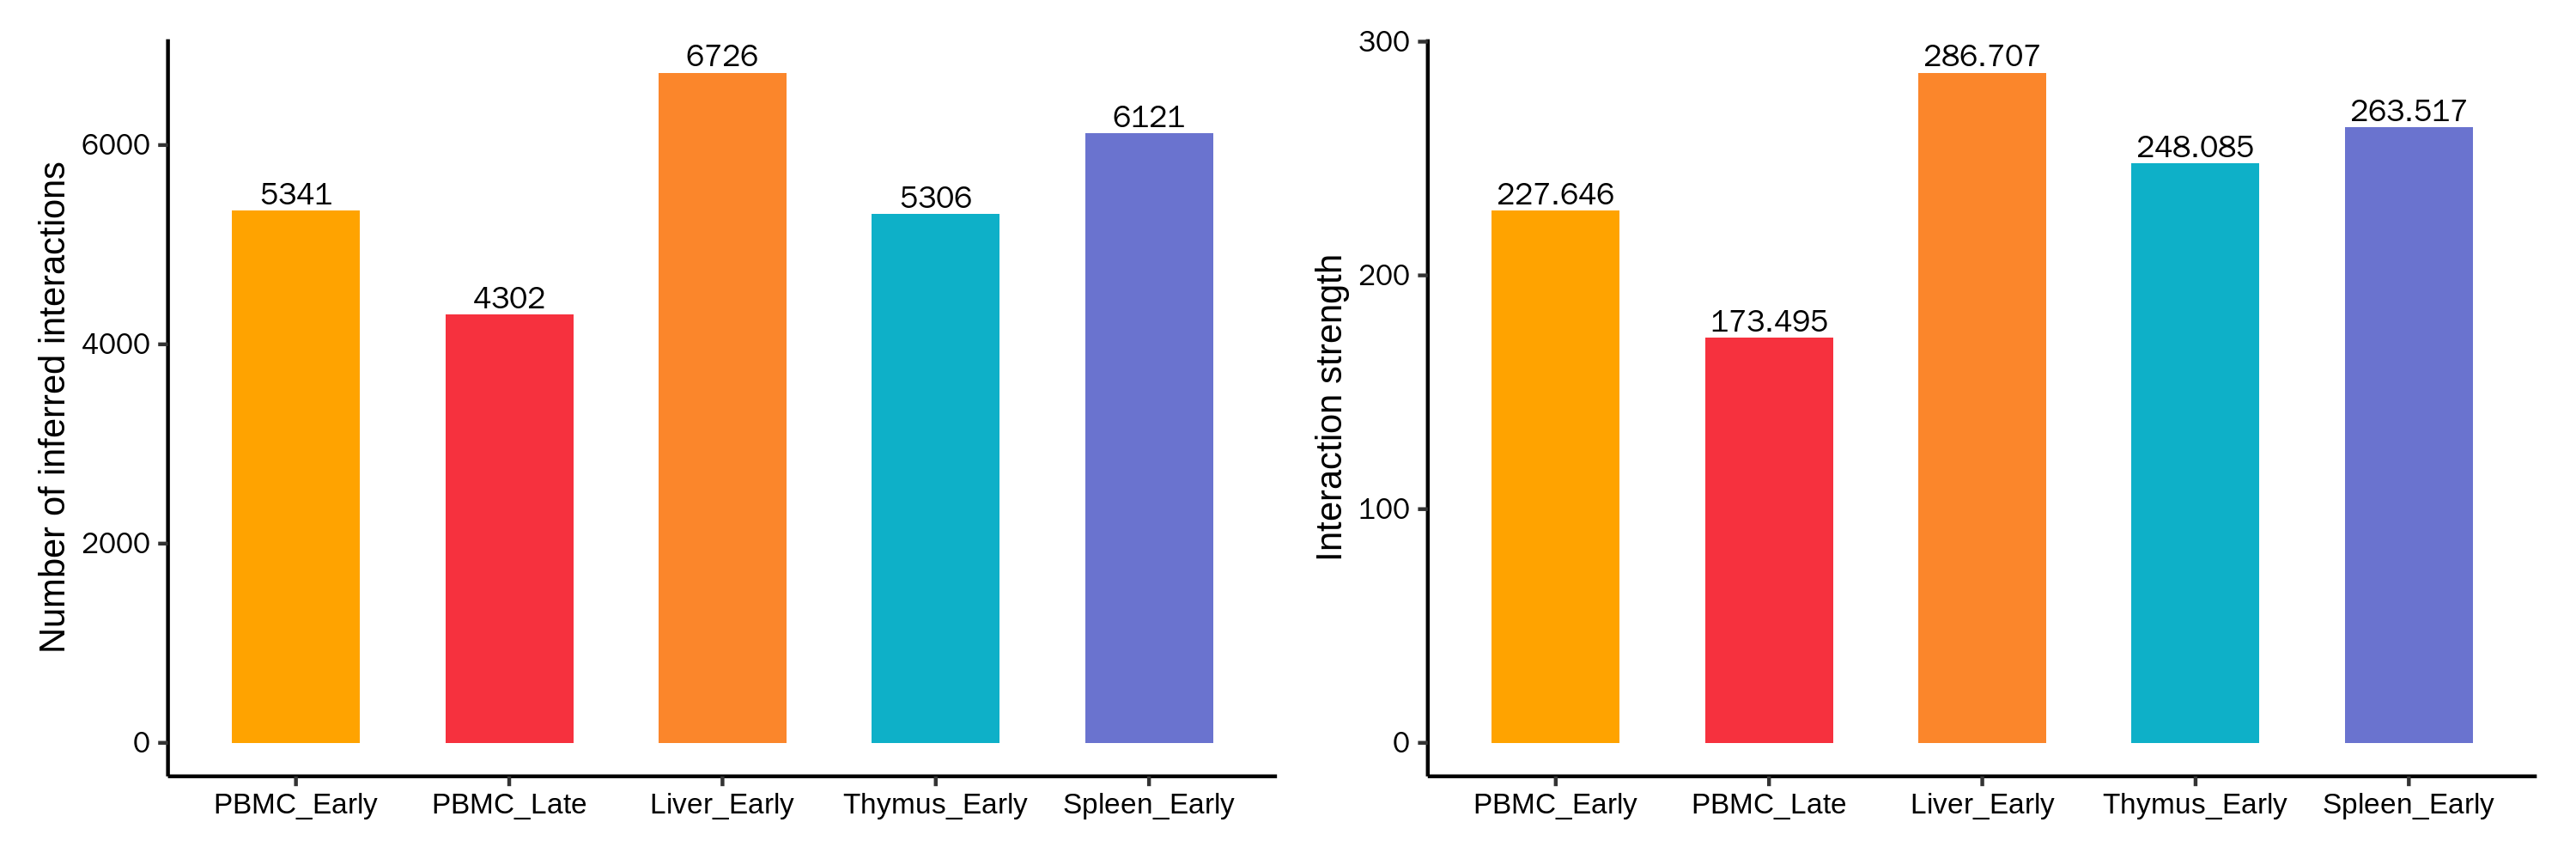

In [42]:
%%R -w 3000 -h 1000 -r 300
gg1 <- compareInteractions(Organ_cellchat2 , show.legend = F, group = c(1,2,3,4,5))+scale_fill_manual(values = c("#FFA300","#F6313E", "#fb862b", "#0eb0c8", "#6a73cf"))
gg2 <- compareInteractions(Organ_cellchat2 , show.legend = F, group = c(1,2,3,4,5), measure = "weight")+scale_fill_manual(values = c("#FFA300","#F6313E", "#fb862b", "#0eb0c8", "#6a73cf"))
gg1 + gg2

In [43]:
%%R
object.list=Organ_results
object.list <- lapply(object.list, function(x) netAnalysis_computeCentrality(x, slot.name = "netP"))

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~06s           |++++                                              | 7 % ~10s           |+++++                                             | 10% ~08s           |+++++++                                           | 13% ~07s           |+++++++++                                         | 17% ~07s           |++++++++++                                        | 20% ~06s           |++++++++++++                                      | 23% ~07s           |++++++++++++++                                    | 27% ~07s           |+++++++++++++++                                   | 30% ~06s           |+++++++++++++++++                                 | 33% ~06s           |+++++++++++++++++++                               | 37% ~05s           |++++++++++++++++++++                              | 40% ~04s           |++++++++++++++++++++++                            | 43% ~04s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~23s           |+++                                               | 5 % ~15s           |++++                                              | 7 % ~15s           |+++++                                             | 10% ~14s           |+++++++                                           | 12% ~13s           |++++++++                                          | 15% ~12s           |+++++++++                                         | 17% ~12s           |++++++++++                                        | 20% ~10s           |+++++++++++                                       | 22% ~10s           |+++++++++++++                                     | 24% ~09s           |++++++++++++++                                    | 27% ~08s           |+++++++++++++++                                   | 29% ~08s           |++++++++++++++++                                  | 32% ~07s 

In [44]:
%%R
names(object.list)<-GroupStat_ids 

In [45]:
# %%R
# num.link

In [46]:
%%R -w 3000 -h 1200 -r 180
library(ggsci)
cols01 <- c("#f49128", "#194a55", "#187c65", "#f26115", "#c29f62", "#83ba9e")
cols02 <- c("#c62d17", "#023f75", "#ea894e", "#266b69", "#eb4601", "#f6c619")
cols03 <- c("#fa6e01", "#2f2f2f", "#972b1d", "#e6a84b", "#4c211b", "#ff717f")
cols04 <- c("#223e9c", "#b12b23", "#aebea6", "#edae11", "#0f6657", "#c74732")
cols05 <- c("#6a73cf", "#edd064", "#0eb0c8", "#f2ccac", "#a1d5b9", "#e1abbc")

all_colors <- c(cols01, cols02, cols03, cols04, cols05)
all_colors
colorname2=c(pal_futurama()(3),"#46A040","#00AF99" ,"#F6313E", "#FFA300","#2f2f2f",  "#FFC179", 
"#FF5A00", "#663366","#FF6666","#8F1336", "#0081C9", "#001588", "#CC0033",
"#CC9966","#CC0033","#999933","#009966","#CCCC33","#CCFF99","#0eb0c8","#993333","#333366",
"#490C65", "#BA7FD0","#A6CEE3", "#1F78B4", "#DE77AE", "#B2DF8A", "#006D2C", "#B5AD64",
"#9DA8E2","#91C392", "#194a55", "#187c65", "#c29f62","#f49128","#c62d17", "#333329",
"#023f75", "#ea894e", "#266b69",  "#e1abbc","#f6c619","#fa6e01", "#972b1d", "#e6a84b", "#4c211b", "#ff717f","#223e9c", 
"#aebea6", "#edae11", "#c74732", "#6a73cf", "#edd064" , 
"#0eb0c8", "#f2ccac" ,"#868686","#339966", "#83ba9e", "#b12b23", "#0f6657","#f26115","#eb4601")
colorname3=colorname2
length(colorname3)

[1] 66


In [47]:
ls /home/maolp/Allcount/Last_All_scanpyData/ColorDict/

Cell_graident_colors.json*           Celltype_colors_dict.json*
Cell_graident_colors_prefixed.json*  Celltype_colors_dict_nonum.json*


In [48]:
%%R -w 1800 -h 2600 -r 180

library(jsonlite)


file_path <- "/home/maolp/Allcount/Last_All_scanpyData/ColorDict/Celltype_colors_dict_nonum.json"
colors_dict <- fromJSON(file_path)
colors_dict

$`CXCR5+ Naïve B`
[1] "#C71000FF"

$`CXCR5- Naïve B`
[1] "#008EA0FF"

$`Naïve CD4 T`
[1] "#8A4198FF"

$`Gamma Delta V2 T`
[1] "#5A9599FF"

$`Naïve CD8 T`
[1] "#FF6348FF"

$`Classical Monocytes`
[1] "#84D7E1FF"

$Late_ERY
[1] "#FF95A8FF"

$Treg
[1] "#3D3B25FF"

$`abT(entry)`
[1] "#ADE2D0FF"

$`CX3CR1+ NK`
[1] "#1A5354FF"

$Macrophages
[1] "#3F4041FF"

$`DN(Q) T`
[1] "#fa6e01"

$Mid_ERY
[1] "#972b1d"

$Th17like_INNATE_T
[1] "#e6a84b"

$`DP(P) T`
[1] "#4c211b"

$`CXCR6+ NK`
[1] "#ff717f"

$`CD14+PPBP+ Monocytes`
[1] "#009966"

$Megakaryocytes
[1] "#c62d17"

$`CD56highCD16low NK`
[1] "#023f75"

$`DP(Q) T`
[1] "#ea894e"

$`Small pre-B`
[1] "#266b69"

$`GNG4 +CD8aa+T`
[1] "#eb4601"

$`Myeloid-CD177`
[1] "#f6c619"

$Early_ERY
[1] "#f49128"

$`Endothelial cells`
[1] "#194a55"

$`NK T`
[1] "#c29f62"

$DC2
[1] "#83ba9e"

$`Pro-B`
[1] "#187c65"

$DC1
[1] "#A6CEE3"

$HSC_MPP
[1] "#223e9c"

$MEP
[1] "#aebea6"

$`ILC2/3`
[1] "#edae11"

$pDC
[1] "#0f6657"

$`Large pre-B`
[1] "#c74732"

$Tem
[1] "#6a7

R[write to console]: Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

R[write to console]: Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

R[write to console]: Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

R[write to console]: Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

R[write to console]: Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways



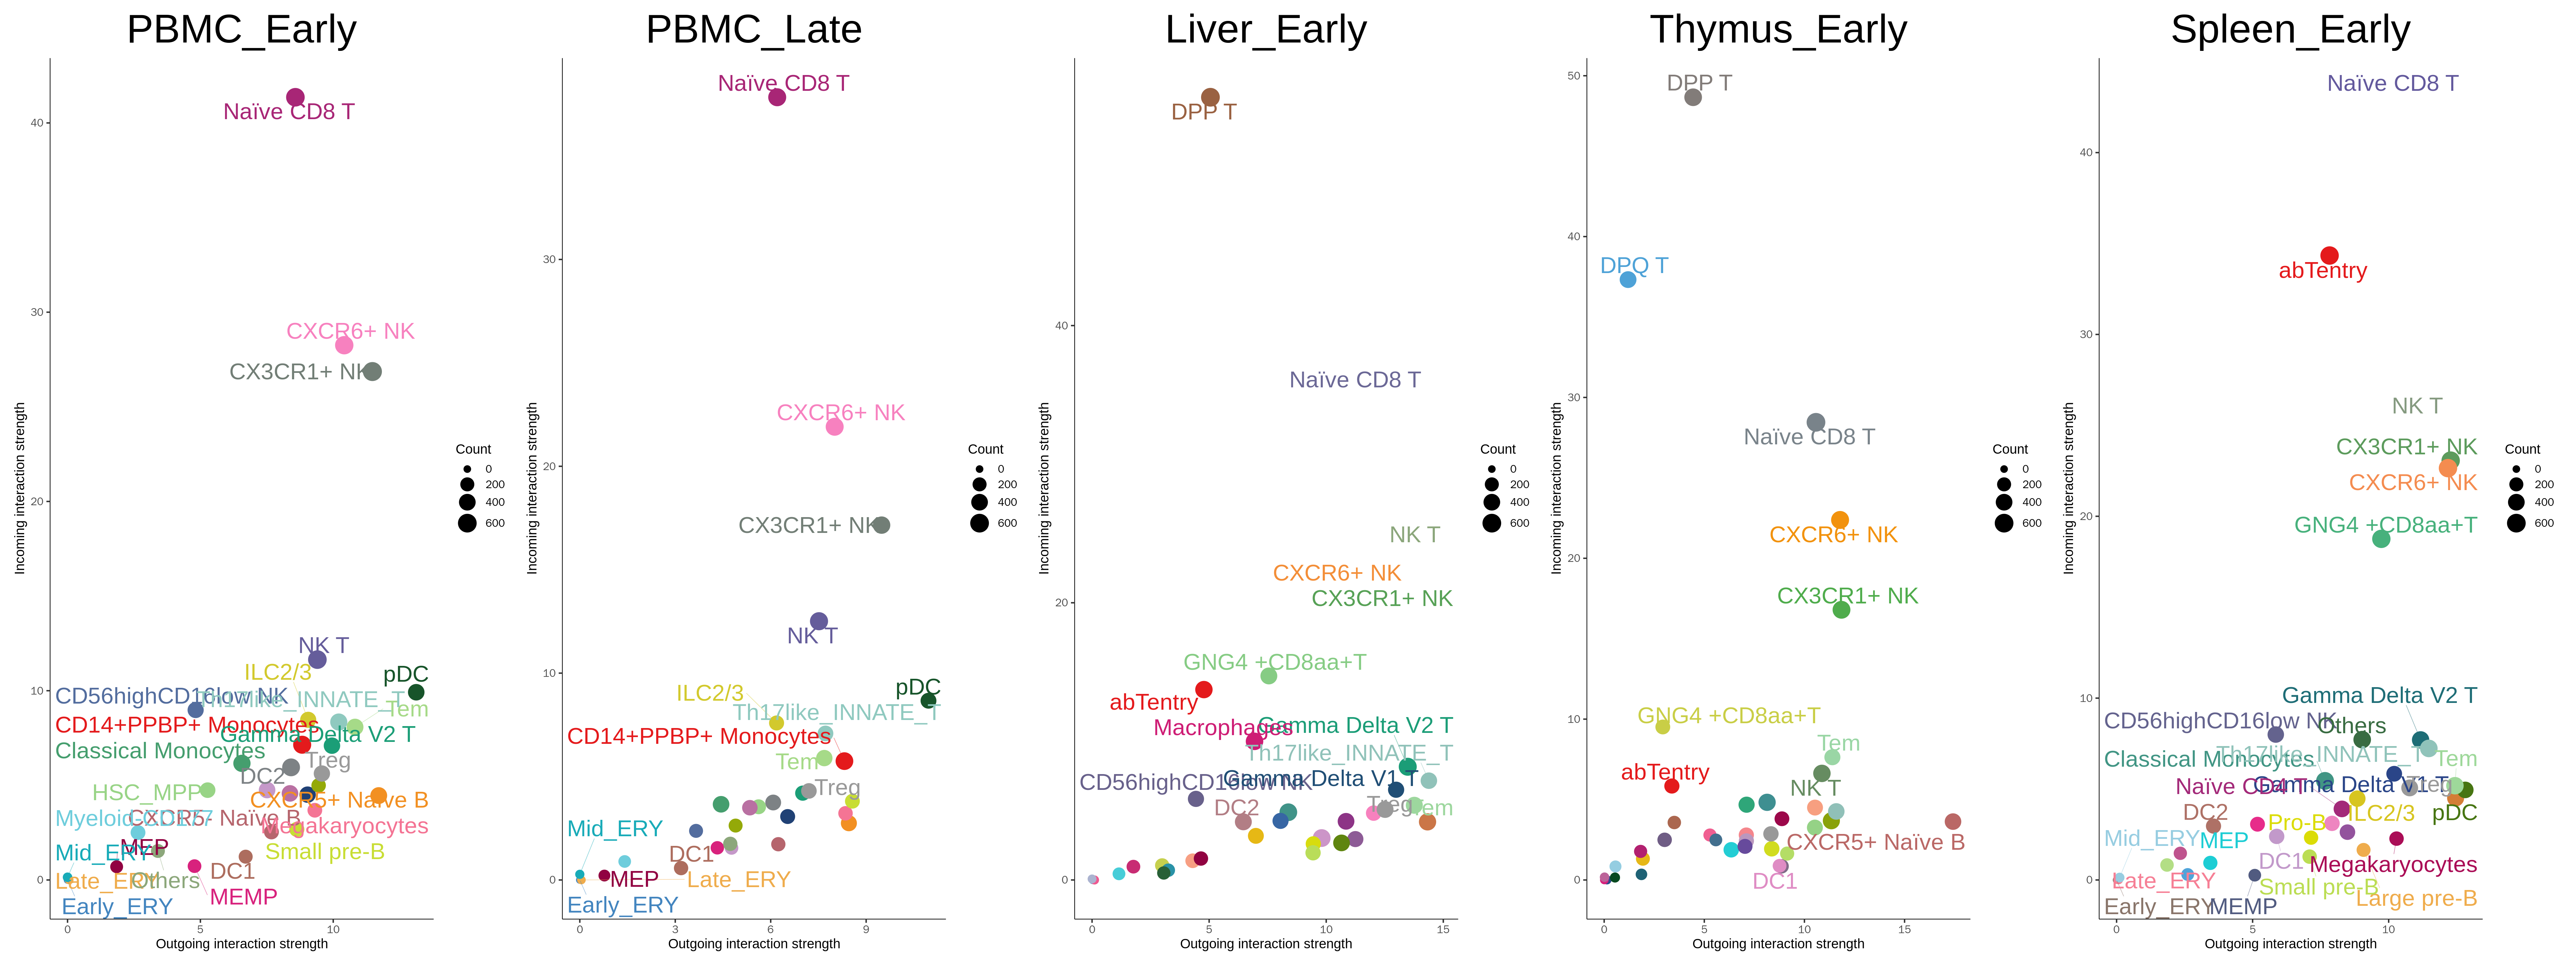

In [49]:
%%R -w 8000 -h 3000 -r 300

num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count)-diag(x@net$count)})
num.link 
weight.MinMax <- c(0,643) 

gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], 
                                               title = names(object.list)[i], weight.MinMax = weight.MinMax, label.size = 6,
                                               font.size.title = 30)
#     ylab("")+theme(
#       axis.title.x = element_text(size=18), axis.text.x= element_text(size=18),
#                                                                  axis.ticks.y = element_line(size = 2),  #
#                                                             axis.text.y = element_text(size = 14)) + scale_color_manual(values = colors_dict)+
#     scale_y_continuous(breaks = seq(0, 50, by = 10))+coord_cartesian(ylim = c(0, 50),xlim = c(0, 18))+scale_x_continuous(breaks = seq(0, 18, by = 3))
}
patchwork::wrap_plots(plots = gg,ncol=5)

In [50]:
%%R -w 6000 -h 3000 -r 300
pdf("/home/maolp/Allcount/Last_All_scanpyData/Cellchat/Organall.pdf",width=40,height=10)
print(patchwork::wrap_plots(plots = gg,ncol=5))
dev.off()

png 
  2 


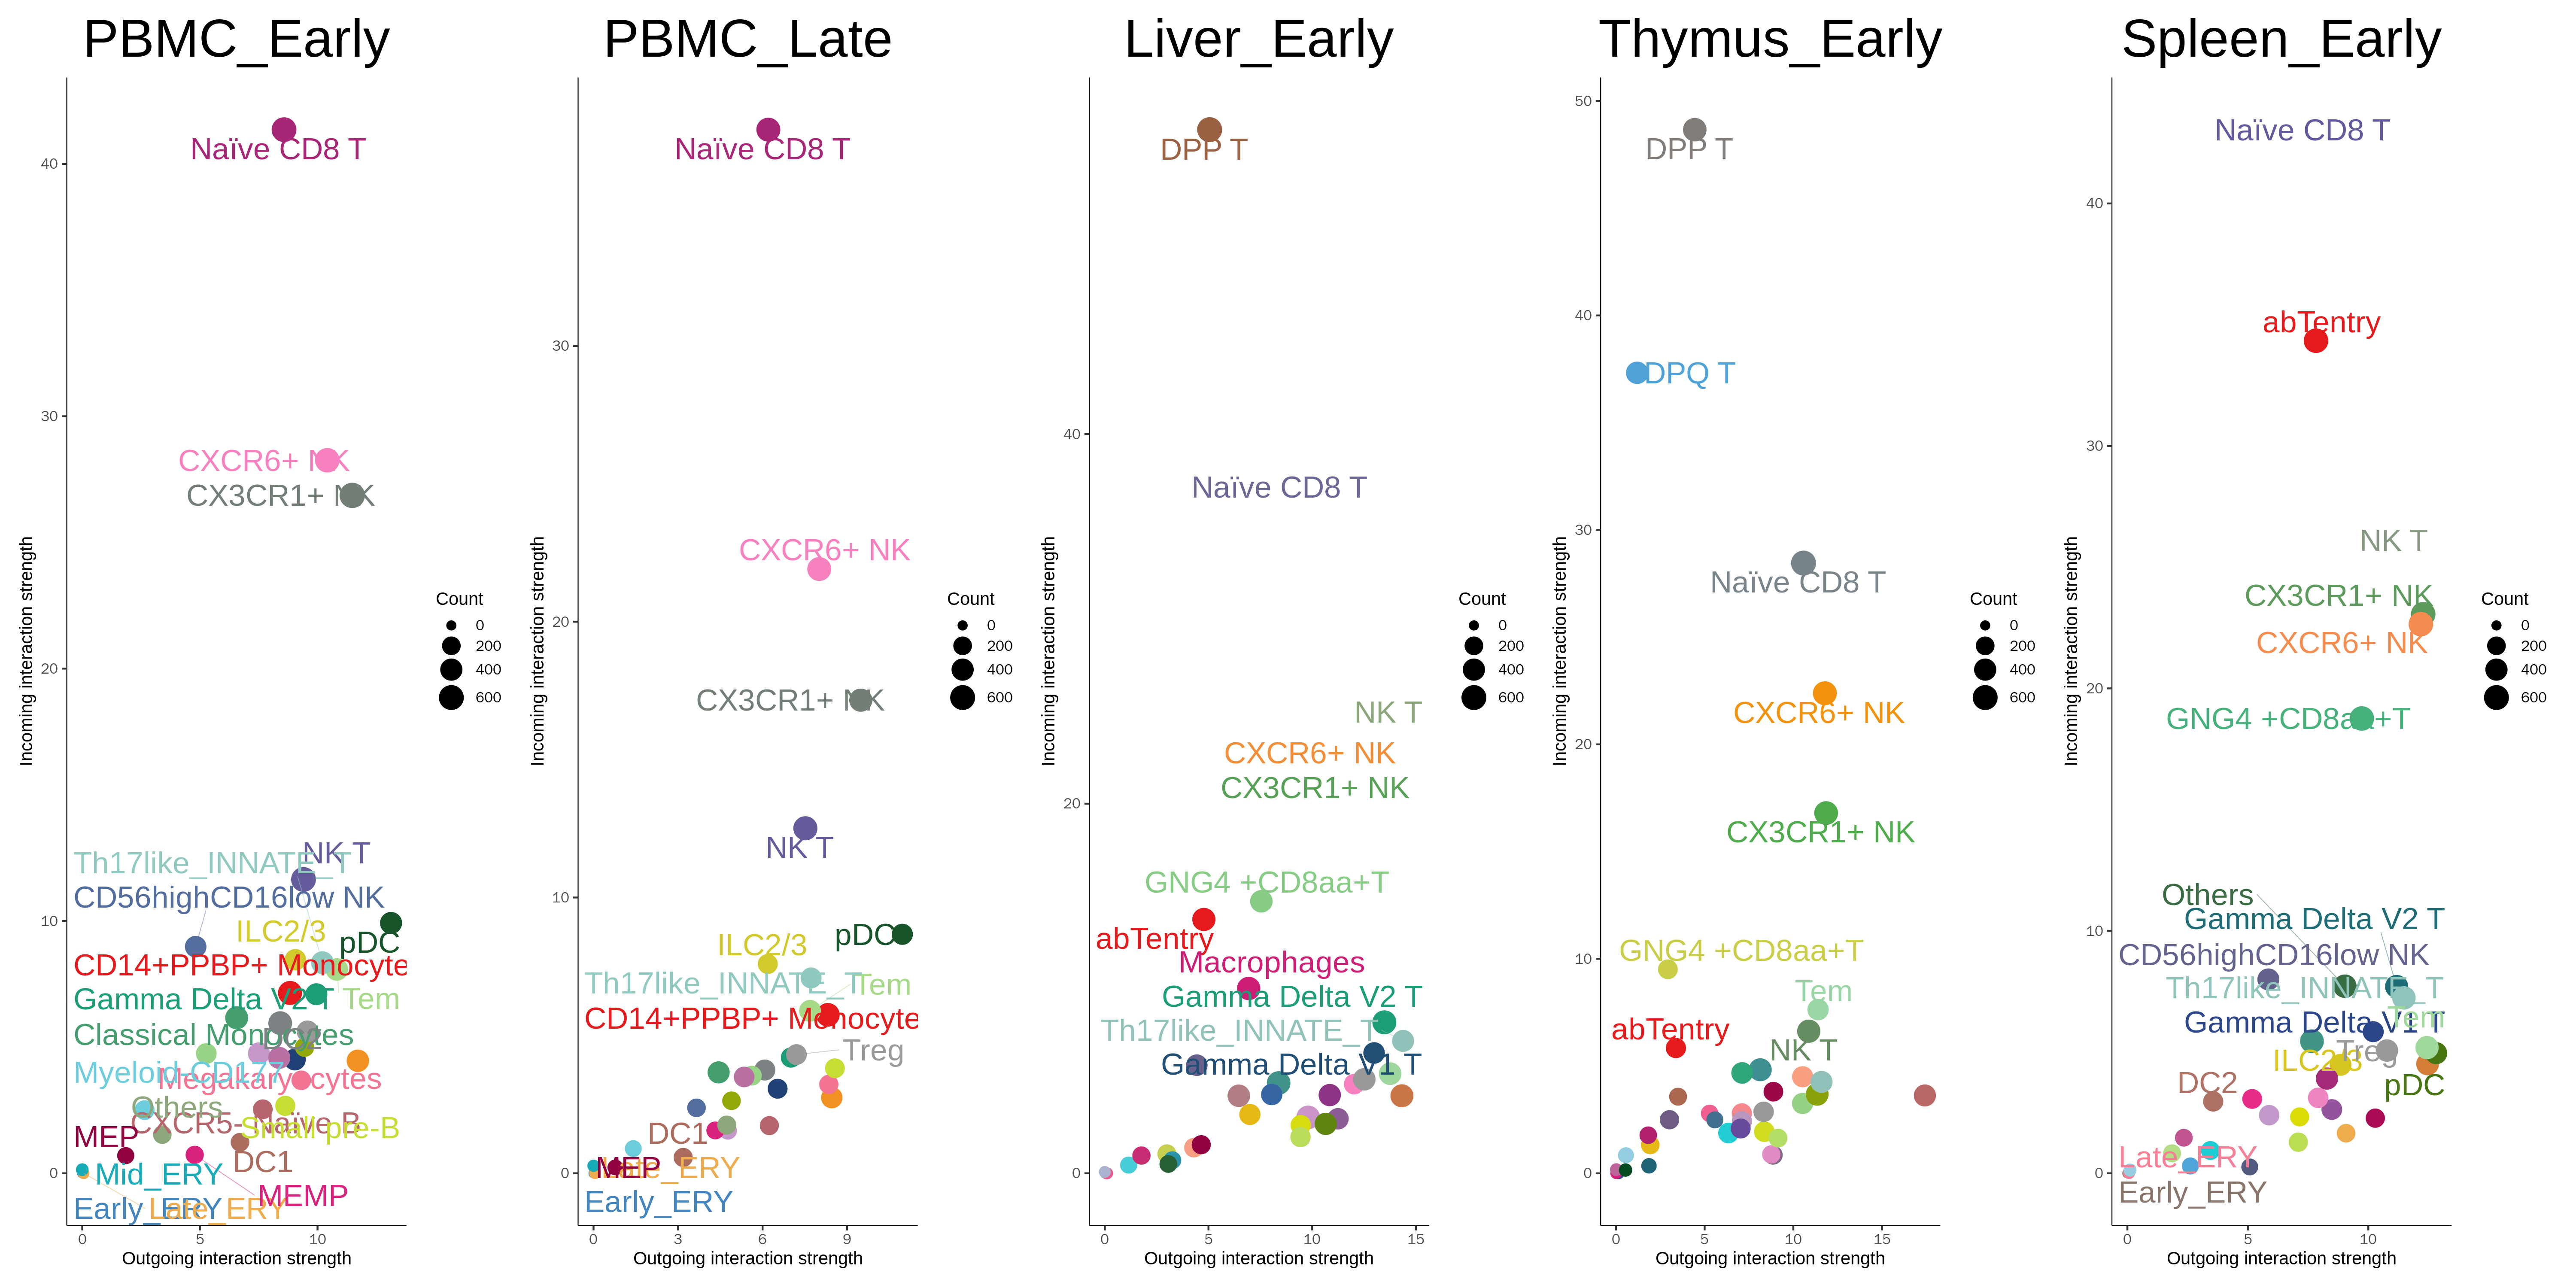

In [51]:
%%R -w 6000 -h 3000 -r 300
library(patchwork)


for (i in 2:5) {
  gg[[i]] <- gg[[i]] + guides(color = FALSE, fill = FALSE)
}


p <- wrap_plots(plots = gg, ncol = 5)

print(p)

In [52]:
%%R -w 6000 -h 3000 -r 300
pdf("/home/maolp/Allcount/Last_All_scanpyData/Cellchat/Organall.pdf",width=40,height=10)
print(p)
dev.off()

png 
  2 


In [53]:
%%R
process_cellchat2 <- function(adata, adjusted_id) {
  subset_data <- subset(adata, AdjustedID == adjusted_id)
  data.pbmc <- subset_data@assays$RNA@data
  cellmeta <- data.frame(group = as.character(subset_data$Cell_lineage), row.names = names(subset_data$Cell_lineage))
  
  cellchat <- createCellChat(object = data.pbmc)
  cellchat <- addMeta(cellchat, meta = cellmeta, meta.name = "labels")
  cellchat <- setIdent(cellchat, ident.use = "labels")
  
  CellChatDB <- CellChatDB.human
  CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact", key = "annotation")
  cellchat@DB <- CellChatDB.use
  
  cellchat <- subsetData(cellchat)
  cellchat <- identifyOverExpressedGenes(cellchat)
  cellchat <- identifyOverExpressedInteractions(cellchat)
  cellchat <- projectData(cellchat, PPI.human)

  cellchat <- computeCommunProb(cellchat)
  cellchat <- computeCommunProbPathway(cellchat)
  cellchat <- aggregateNet(cellchat)
  
  return(cellchat)
}

# Get a list of all unique AdjustedID values
adjusted_ids <- levels(adata1$AdjustedID)
adjusted_ids 
# # Run the function on all AdjustedID values and store the results in a list
# results2 <- lapply(adjusted_ids, function(id) process_cellchat2(adata1, id))

# # Save the results as an RDS file
# saveRDS(results2, file = "/home/maolp/Allcount/Last_All_scanpyData/Cellchat/Allcellchat_results_celllieange.rds")

 [1] "B11.6_P24" "B12.0_P2"  "B17.4_P3"  "B18.0_P4"  "B18.6_P5"  "B20.9_P7" 
 [7] "B21.7_P8"  "B22.4_P9"  "B22.4_P23" "B23.4_P10" "B24.6_P11" "B26.9_P12"
[13] "B29.1_P13" "B30.4_P14" "B31.3_P15" "B32.4_P16" "B33.3_P17" "B34.1_P18"
[19] "B36.1_P19" "B37.9_P20" "B38.1_P21" "B39.1_P22" "L10.0_P1"  "L10.1_P25"
[25] "L18.6_P5"  "L24.6_P11" "S18.6_P5"  "S24.6_P11" "T10.0_P1"  "T10.1_P25"
[31] "T18.6_P5"  "T24.6_P11"


In [54]:
%%R

x <- levels(adata1$AdjustedID)

order <- c(grep("^[^TS]", x),grep("^T", x), grep("^S", x))


x <- x[match(order, seq_along(x))]

print(x)
adjusted_ids=x

results2 <- lapply(adjusted_ids, function(id) process_cellchat2(adata1, id))

# # Save the results as an RDS file
saveRDS(results2, file = "/home/maolp/Allcount/Last_All_scanpyData/Cellchat/Allcellchat_results_celllieange.rds")

 [1] "B11.6_P24" "B12.0_P2"  "B17.4_P3"  "B18.0_P4"  "B18.6_P5"  "B20.9_P7" 
 [7] "B21.7_P8"  "B22.4_P9"  "B22.4_P23" "B23.4_P10" "B24.6_P11" "B26.9_P12"
[13] "B29.1_P13" "B30.4_P14" "B31.3_P15" "B32.4_P16" "B33.3_P17" "B34.1_P18"
[19] "B36.1_P19" "B37.9_P20" "B38.1_P21" "B39.1_P22" "L10.0_P1"  "L10.1_P25"
[25] "L18.6_P5"  "L24.6_P11" "T10.0_P1"  "T10.1_P25" "T18.6_P5"  "T24.6_P11"
[31] "S18.6_P5"  "S24.6_P11"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-12-11 16:25:32]"


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |==                                                                    |   4%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================         

  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:26:30]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++              

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 12% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 30% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |======                                                                |   9%
  |                                                                            
  |========                                                              |  11%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:27:26]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                          

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~00s           |++++                                              | 8 % ~00s           |++++++                                            | 12% ~00s           |++++++++                                          | 15% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 35% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++                            | 42% ~00s           |++++++++++++++++++++++++                          | 46% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================       

  |                                                                            
  |========================================================              |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |========================================================              |  81%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  82%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:28:34]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |++++++++++++++                                    | 28% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~00s           |++++                                              | 7 % ~00s           |++++++                                            | 11% ~00s           |++++++++                                          | 15% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |+++++++++++++++++++++                             | 41% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 48% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================         

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:29:42]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s           |++++++++++++++                                    | 27% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |===                                                                   |   5%
  |                                     

  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================         

  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |===================================================                   |  74%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:31:16]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                          

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 12% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 30% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================      

  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:32:29]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~00s           |+++++++++++                                       | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 24% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |==                                                                    |   4%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:33:36]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                         

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~00s           |++++++++++++++                                    | 26% ~00s           |+++++++++++++++                                   | 28% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 29% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  37%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:35:00]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |++++++                           

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |++++++++                                          | 14% ~02s           |++++++++                                          | 16% ~02s           |+++++++++                                         | 18% ~02s           |++++++++++                                        | 19% ~02s           |+++++++++++                                       | 21% ~02s           |++++++++++++                                      | 23% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 17% ~02s           |++++++++++                                        | 19% ~02s           |+++++++++++                                       | 21% ~02s           |++++++++++++                                      | 23% ~02s           |+++++++++++++                                     | 25% ~02s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |===                                                                   |   5%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================         

  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:36:51]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |+++++++++++++                                     | 25% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================         

  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:38:20]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~00s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~00s           |++++++++++                                        | 20% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 6 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |++++++++                                          | 14% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 37% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 20% ~00s           |++++++++++++                                      | 22% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================      

  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |========================================================              |  81%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:39:28]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                         

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 9 % ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |++++++++++                                        | 18% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |++++++++++++++++                                  | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 36% ~00s           |++++++++++++++++++++                              | 39% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================      

  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  82%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:40:54]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 4 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 18% ~00s           |+++++++++++                                       | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================       

  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  79%
  |                                                                            
  |========================================================              |  80%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:42:03]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                         

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 32% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~02s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================         

  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:43:46]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:45:09]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |++++                                              | 7 % ~00s           |+++++++                                           | 13% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++                              | 40% ~00s           |++++++++++++++++++++++++                          | 47% ~00s           |+++++++++++++++++++++++++++                       | 53% ~00s           |++++++++++++++++++++++++++++++                    | 60% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++             | 73% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~00s           |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 7 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 17% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 34% ~00s           |+++++++++++++++++++                               | 38% ~00s           |+++++++++++++++++++++                             | 41% ~00s           |+++++++++++++++++++++++                           | 45% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================      

  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:46:31]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 32% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================       

  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |=========================================================             |  81%
  |                                                                            
  |=========================================================             |  82%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:47:57]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~00s           |++++                                              | 7 % ~00s           |++++++                                            | 11% ~00s           |++++++++                                          | 14% ~00s           |+++++++++                                         | 18% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 36% ~00s           |++++++++++++++++++++                              | 39% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |++++++++++++++++++++++++                          | 46% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |===                                                                   |   5%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================         

  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:49:23]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~00s           |++++++++                                          | 16% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 22% ~00s           |++++++++++++                                      | 24% ~00s           |+++++++++++++                                     | 26% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 4 % ~01s           |++++                                              | 7 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 22% ~00s           |++++++++++++                                      | 24% ~00s           |++++++++++++++                                    | 26% ~00s           |+++++++++++++++                                   | 28% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:50:40]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~01s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |===                                                                   |   5%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================         

  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:52:29]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 18% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 22% ~00s           |++++++++++++                                      | 24% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |==                                                                    |   4%
  |                                     

  |========================                                              |  34%
  |                                                                            
  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================           

  |                                                                            
  |================================================                      |  69%
  |                                                                            
  |=================================================                     |  69%
  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |=================================================                     |  71%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:53:51]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |==                                                                    |   4%
  |                                     

  |==========================                                            |  37%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:55:20]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                      

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 18% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 21% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 18% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~00s           |++++                                              | 8 % ~00s           |++++++                                            | 12% ~00s           |++++++++                                          | 15% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 23% ~00s           |++++++++++++++                                    | 27% ~00s           |++++++++++++++++                                  | 31% ~00s           |++++++++++++++++++                                | 35% ~00s           |++++++++++++++++++++                              | 38% ~00s           |++++++++++++++++++++++                            | 42% ~00s           |++++++++++++++++++++++++                          | 46% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================                                       |  44%
  |                                                                            
  |===============================                                       |  45%
  |                                                                            
  |================================     

  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                                                            
  |===========================================================           |  84%
  |                                                                            
  |===========================================================           |  85%
  |                                                                            
  |============================================================          |  85%
  |                                                                            
  |============================================================          |  86%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:56:19]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                         

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~00s           |++++++++                                          | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 18% ~00s           |+++++++++++                                       | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================         

  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                                                            
  |===================================================                   |  72%
  |                                                                            
  |===================================================                   |  73%
  |                                                                            
  |====================================================                  |  74%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:57:44]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 13% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 35% ~00s           |++++++++++++++++++++                              | 39% ~00s           |+++++++++++++++++++++                             | 42% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 4 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 27% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 16:59:04]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                         

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 20% ~00s           |+++++++++++                                       | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++                                  | 32% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================        

  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:00:24]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 4 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 16% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                    

  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++            | 75% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 25% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 9 % ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |++++++++++                                        | 18% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |++++++++++++++++                                  | 30% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 36% ~00s           |++++++++++++++++++++                              | 39% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================                                       |  44%
  |                                                                            
  |===============================                                       |  45%
  |                                                                            
  |================================     

  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                                                            
  |===========================================================           |  84%
  |                                                                            
  |============================================================          |  85%
  |                                                                            
  |============================================================          |  86%
  |                                                                            
  |=============================================================         |  87%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:01:45]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                    

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 35% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~00s           |++++++++++++                                      | 22% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:03:08]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 18% ~00s           |++++++++++                                        | 20% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 28% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 35% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================        

  |                                                                            
  |=========================================================             |  82%
  |                                                                            
  |==========================================================            |  82%
  |                                                                            
  |==========================================================            |  83%
  |                                                                            
  |===========================================================           |  84%
  |                                                                            
  |===========================================================           |  85%
  |                                                                            
  |============================================================          |  85%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:04:29]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                      

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~00s           |+++                                               | 4 % ~00s           |++++                                              | 6 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 10% ~00s           |+++++++                                           | 12% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 21% ~00s           |++++++++++++                                      | 23% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 27% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================                                        |  42%
  |                                                                            
  |==============================                                        |  43%
  |                                                                            
  |===============================                                       |  44%
  |                                                                            
  |===============================                                       |  45%
  |                                                                            
  |================================     

  |                                                                            
  |==========================================================            |  83%
  |                                                                            
  |===========================================================           |  84%
  |                                                                            
  |===========================================================           |  85%
  |                                                                            
  |============================================================          |  85%
  |                                                                            
  |============================================================          |  86%
  |                                                                            
  |=============================================================         |  87%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:05:41]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                       

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 20% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 24% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |============================                                          |  41%
  |                                                                            
  |=============================                                         |  41%
  |                                                                            
  |=============================                                         |  42%
  |                                                                            
  |==============================       

  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                                                            
  |=======================================================               |  79%
  |                                                                            
  |========================================================              |  80%
  |                                                                            
  |=========================================================             |  81%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:07:13]"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                        

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 16% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 18% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |++++++++++++                                      | 24% ~01s           |+++++++++++++                                     | 25% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 22% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                     

  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================                                           |  38%
  |                                                                            
  |===========================                                           |  39%
  |                                                                            
  |============================                                          |  39%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |=============================        

  |                                                                            
  |====================================================                  |  75%
  |                                                                            
  |=====================================================                 |  75%
  |                                                                            
  |=====================================================                 |  76%
  |                                                                            
  |======================================================                |  77%
  |                                                                            
  |======================================================                |  78%
  |                                                                            
  |=======================================================               |  78%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-11 17:08:44]"


In [55]:
%%R -w 6000 -h 3000 -r 300
# object.list=GroupStat_res2
object.list[[1]]=netAnalysis_computeCentrality(object.list[[1]], slot.name = "netP") 
object.list[[2]]=netAnalysis_computeCentrality(object.list[[2]], slot.name = "netP") 
object.list[[3]]=netAnalysis_computeCentrality(object.list[[3]], slot.name = "netP") 
object.list[[4]]=netAnalysis_computeCentrality(object.list[[4]], slot.name = "netP") 
object.list[[5]]=netAnalysis_computeCentrality(object.list[[5]], slot.name = "netP") 
# netVisual_bubble(object.list, sources.use = c(1:30), targets.use =1 ,  comparison = c(1, 2), angle.x = 45)

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~06s           |++++                                              | 7 % ~10s           |+++++                                             | 10% ~08s           |+++++++                                           | 13% ~07s           |+++++++++                                         | 17% ~07s           |++++++++++                                        | 20% ~07s           |++++++++++++                                      | 23% ~07s           |++++++++++++++                                    | 27% ~07s           |+++++++++++++++                                   | 30% ~06s           |+++++++++++++++++                                 | 33% ~05s           |+++++++++++++++++++                               | 37% ~05s           |++++++++++++++++++++                              | 40% ~04s           |++++++++++++++++++++++                            | 43% ~04s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~23s           |+++                                               | 5 % ~15s           |++++                                              | 7 % ~12s           |+++++                                             | 10% ~12s           |+++++++                                           | 12% ~12s           |++++++++                                          | 15% ~11s           |+++++++++                                         | 17% ~11s           |++++++++++                                        | 20% ~10s           |+++++++++++                                       | 22% ~10s           |+++++++++++++                                     | 24% ~09s           |++++++++++++++                                    | 27% ~09s           |+++++++++++++++                                   | 29% ~08s           |++++++++++++++++                                  | 32% ~08s 

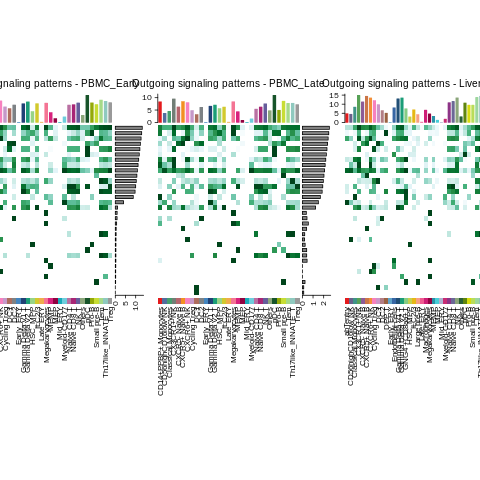

In [56]:
%%R
library(ComplexHeatmap)
i = 1
# combining all the identified signaling pathways from different datasets 
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i+1]]@netP$pathways)
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i], width = 5, height = 6)
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+1], width = 5, height = 6)
ht3 = netAnalysis_signalingRole_heatmap(object.list[[i+2]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+2], width = 5, height = 6)

draw(ht1 + ht2+ht3, ht_gap = unit(0.5, "cm"))

R[write to console]: Comparing communications on a merged object 




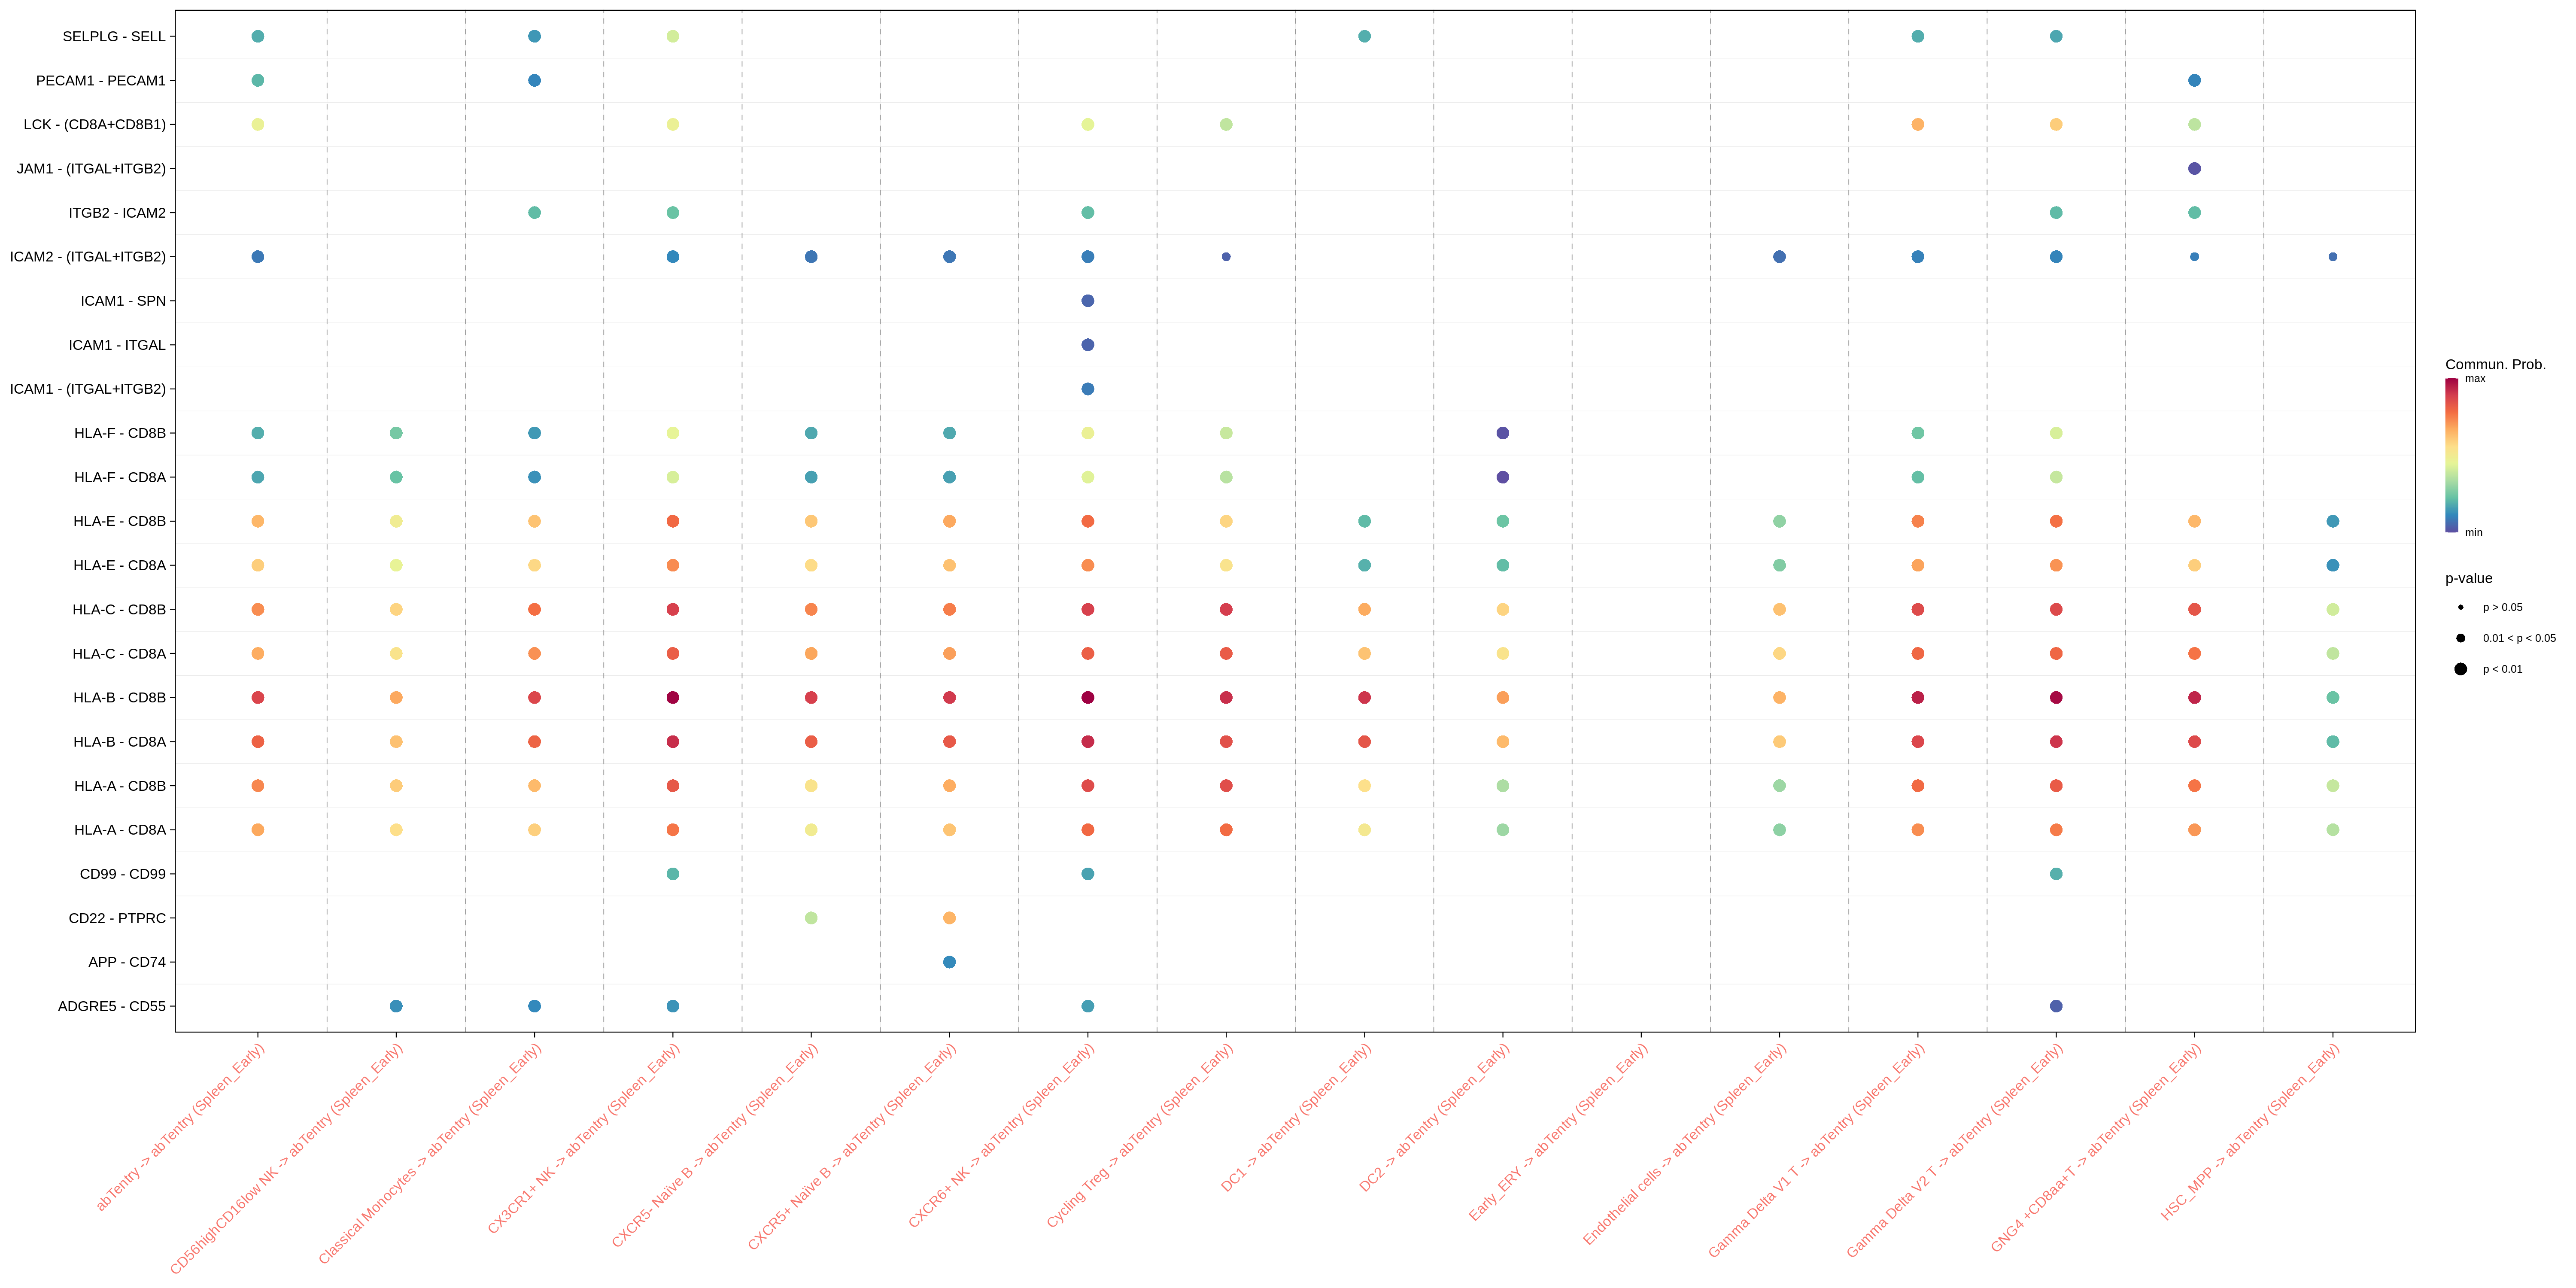

In [57]:
%%R -w 6000 -h 3000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:16) , targets.use = c(1),  comparison = c(5), angle.x = 45)

In [58]:
%%R
# netVisual_bubble

NULL


R[write to console]: Comparing communications on a merged object 




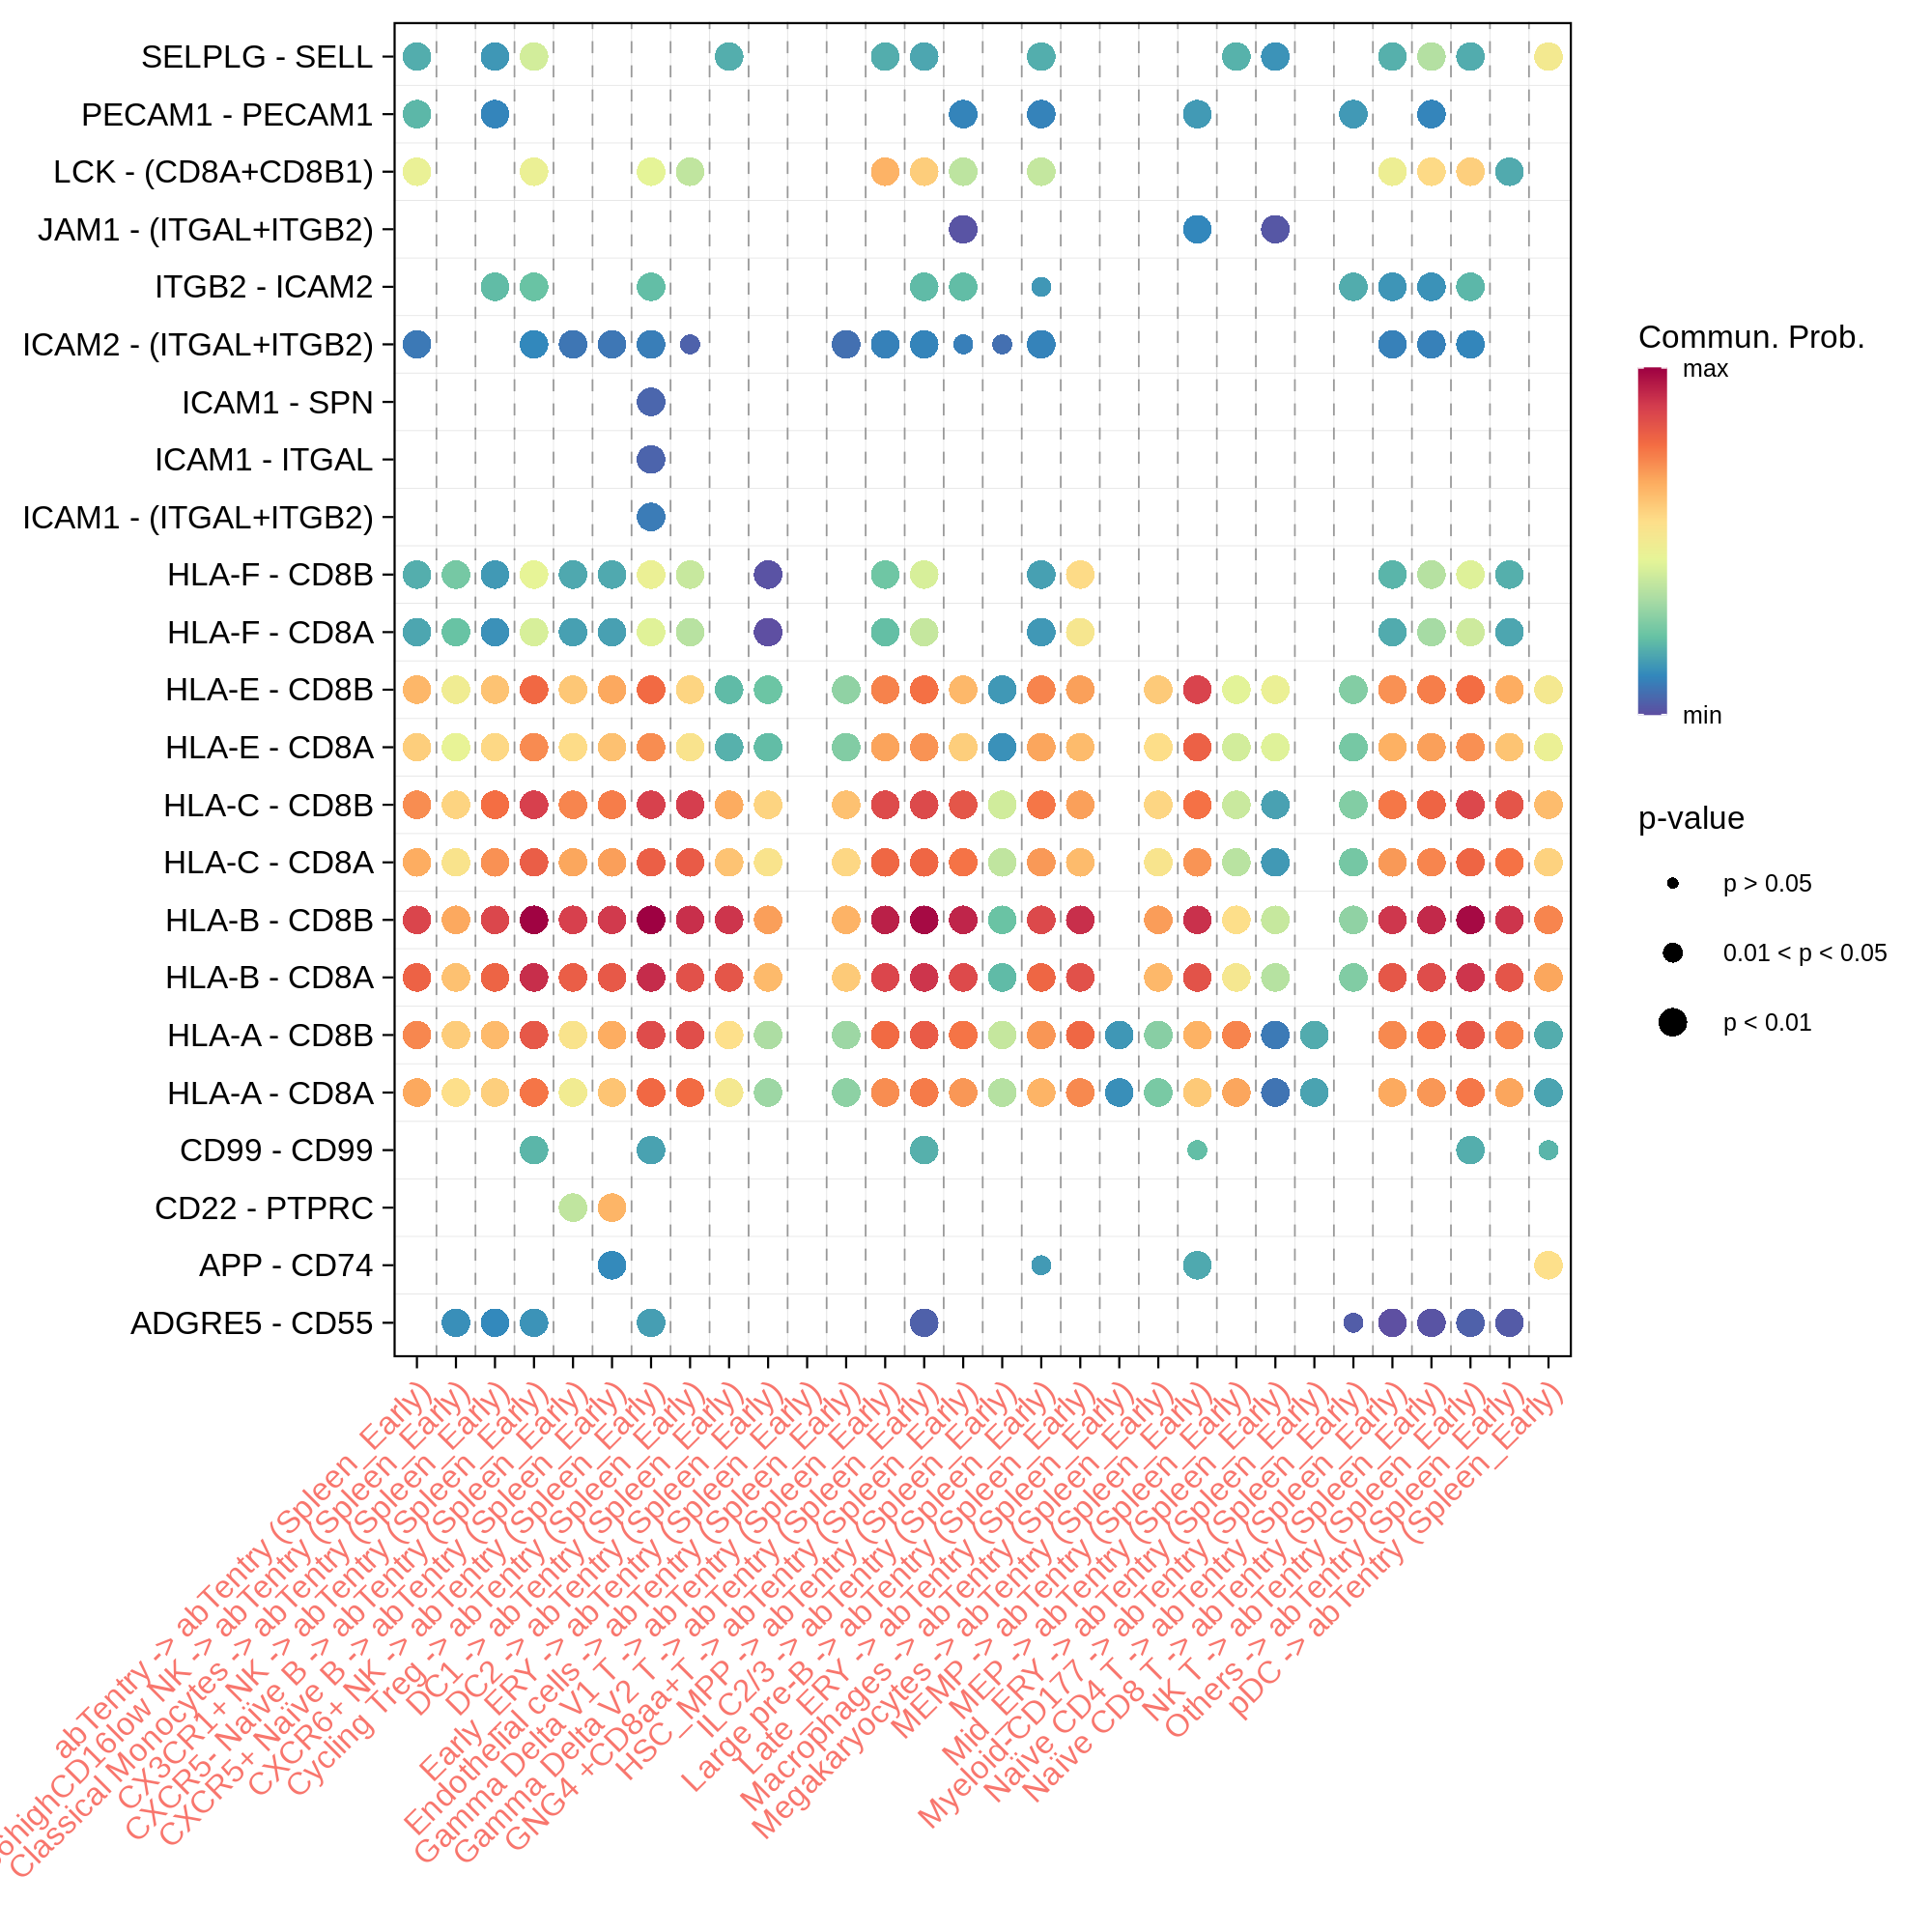

In [59]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:30) , targets.use = c(1),  comparison = c(5), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:30) , targets.use = c(1),  comparison = c(5), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:30) , targets.use = c(11),  comparison = c(3), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:38) , targets.use = c(12),  comparison = c(4), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:38) , targets.use = c(11),  comparison = c(4), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:38) , targets.use = c(30),  comparison = c(4), angle.x = 45)

In [ ]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:38) , targets.use = c(30),  comparison = c(4), angle.x = 45)

In [ ]:
%%R
# Organ_cellchat2@meta.data

In [ ]:
%%R
colnames(Organ_cellchat2@net$Thymus_Early$prob)

In [ ]:
# %%R
# netVisual_bubble